## Task 1: Introduction

Starter notebook for the Coursera Guided Project [Creating Multi Task Models With Keras](https://www.coursera.org/projects/multi-task-models-keras)

In [2]:
%matplotlib inline
%load_ext tensorboard

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil

try:
  shutil.rmtree('logs')
except:
  pass

## Task 2: Create Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [4]:
def create_example(x,y):
  c = np.random.randint(0,2)
  image = 0.5 * np.random.rand(28, 28, 3)
  image[:,:,c] += 0.5 * x / 255
  return image, y, c

digit: 0, color: red


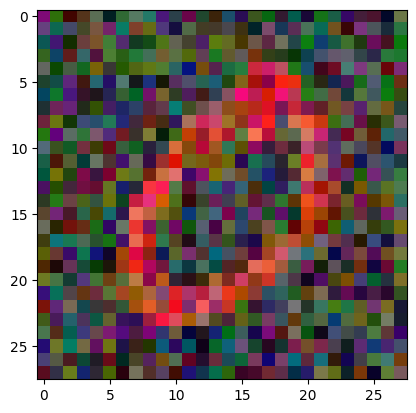

In [5]:
colors = {0:"red", 1: "green"}

x, y, c = create_example(x_train[1], y_train[1])
print(f'digit: {y}, color: {colors[c]}')

plt.imshow(x)
plt.show()

## Task 3: Dataset Generator

In [6]:
def generate_data(x, y, batch_size=32):
  num_examples = len(y)

  while True:
    x_batch = np.zeros((batch_size, 28, 28, 3))
    y_batch = np.zeros((batch_size,))
    c_batch = np.zeros((batch_size,))

    for i in range(0, batch_size):
      index = np.random.randint(0, num_examples)
      image, digit, color = create_example(x[index], y[index])
      x_batch[i] = image
      y_batch[i] = digit
      c_batch[i] = color

    yield x_batch, [y_batch, c_batch]

In [7]:
x, [y, c] = next(generate_data(x_test, y_test, batch_size=1))

[3.] [1.]


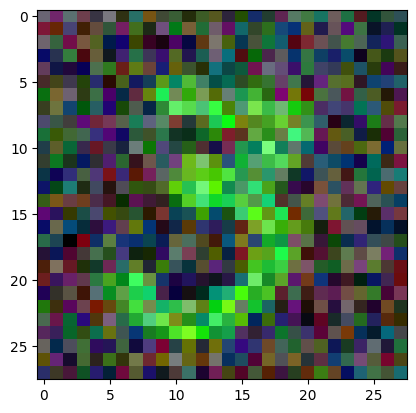

In [8]:
print(y, c)
plt.imshow(x[0]);

## Task 4: Create Model

In [11]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense

input_ = Input(shape=(28,28,3), name='input')

conv_1 = Conv2D(32, 3, name='conv_1')(input_)
act_1 = Activation('relu', name='act_1')(conv_1)

pool_1 = MaxPool2D(4, name='pool_1')(act_1)
flat_1 = Flatten(name='flat_1')(pool_1)

color = Dense(1, activation='sigmoid', name='color')(flat_1)

conv_2 = Conv2D(32, 3, padding='same', name='conv_2')(act_1)
act_2 = Activation('relu', name='act_2')(conv_2)

conv_3 = Conv2D(32, 3, padding='same', name='conv_3')(act_2)
add = Add(name='add')([conv_3, act_1])
act_3 = Activation('relu', name='act_3')(add)

pool_2 = MaxPool2D(4, name='pool_2')(act_3)
flat_2 = Flatten(name='flat_2')(pool_2)

digit = Dense(10, activation='softmax', name='digit')(flat_2)

model = tf.keras.models.Model(input_,[digit, color])

model.compile(
    loss={
        'digit': 'sparse_categorical_crossentropy',
        'color': 'binary_crossentropy'
    },
    optimizer = 'adam',
    metrics = ['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 26, 26, 32)   896         ['input[0][0]']                  
                                                                                                  
 act_1 (Activation)             (None, 26, 26, 32)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 26, 26, 32)   9248        ['act_1[0][0]']                  
                                                                                              

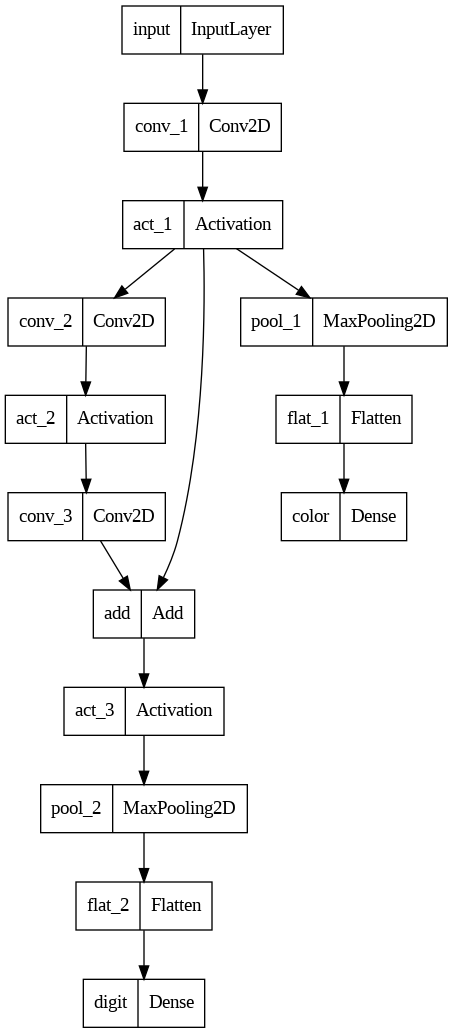

In [13]:
tf.keras.utils.plot_model(model)

## Task 5: Training the Model

In [14]:
class Logger(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    digit_accuracy = logs.get('digit_accuracy')
    color_accuracy = logs.get('color_accuracy')
    val_digit_accuracy = logs.get('val_digit_accuracy')
    val_color_accuracy = logs.get('val_color_accuracy')
    print('='*30, epoch + 1, '='*30)
    print(f'digit_accuracy: {digit_accuracy:.2f}, color_accuracy: {color_accuracy:.2f}')
    print(f'val_digit_accuracy: {val_digit_accuracy:.2f}, val_color_accuracy: {val_color_accuracy:.2f}')

In [17]:
train_gen = generate_data(x_train, y_train)
test_gen = generate_data(x_test, y_test)

_ = model.fit(
    train_gen,
    validation_data = test_gen,
    steps_per_epoch = 200,
    validation_steps = 100,
    epochs = 10,
    callbacks = [
        Logger(),
        tf.keras.callbacks.TensorBoard(log_dir = './logs')
    ],
    verbose=False
)

============================== 1 ==============================
digit_accuracy: 0.59, color_accuracy: 0.96
val_digit_accuracy: 0.79, val_color_accuracy: 1.00
============================== 2 ==============================
digit_accuracy: 0.88, color_accuracy: 1.00
val_digit_accuracy: 0.93, val_color_accuracy: 1.00
============================== 3 ==============================
digit_accuracy: 0.93, color_accuracy: 1.00
val_digit_accuracy: 0.94, val_color_accuracy: 1.00
============================== 4 ==============================
digit_accuracy: 0.94, color_accuracy: 1.00
val_digit_accuracy: 0.96, val_color_accuracy: 1.00
============================== 5 ==============================
digit_accuracy: 0.95, color_accuracy: 1.00
val_digit_accuracy: 0.96, val_color_accuracy: 1.00
============================== 6 ==============================
digit_accuracy: 0.96, color_accuracy: 1.00
val_digit_accuracy: 0.97, val_color_accuracy: 1.00
============================== 7 ===================

In [ ]:
%tensorboard --logdir logs

## Task 6: Final Predictions

In [19]:
def test_model(show=True):
  x, [y, c] = next(test)

  preds = model.predict(x)
  pred_digit = np.argmax(preds[0])
  pred_color = int(preds[1] > 0.5)
  gt_digit = int(y[0])
  gt_color = int(c[0])

  plt.imshow(x[0])
  if show:
    print(f'GT: {gt_digit}, {colors[gt_color]}')
    print(f'Pr: {pred_digit}, {colors[pred_color]}')
    plt.show()
  else:
    col = 'green' if gt_digit == pred_digit and gt_color == pred_color else 'red'
    plt.ylabel(f'GT: {gt_digit}, {colors[gt_color]}', color=col)
    plt.xlabel(f'Pr: {pred_digit}, {colors[pred_color]}', color=col)
    plt.xticks([])
    plt.yticks([])


test = generate_data(x_test, y_test, batch_size=1)

1/1 [==============================] - 0s 275ms/step
GT: 7, green
Pr: 7, green


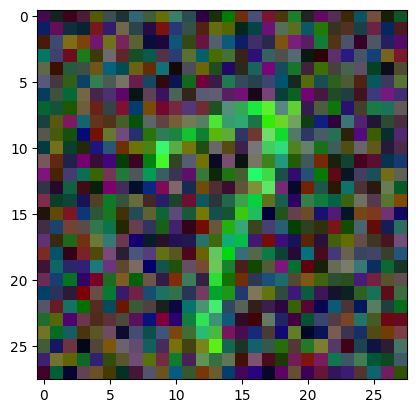

In [20]:
test_model()

1/1 [==============================] - 0s 21ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

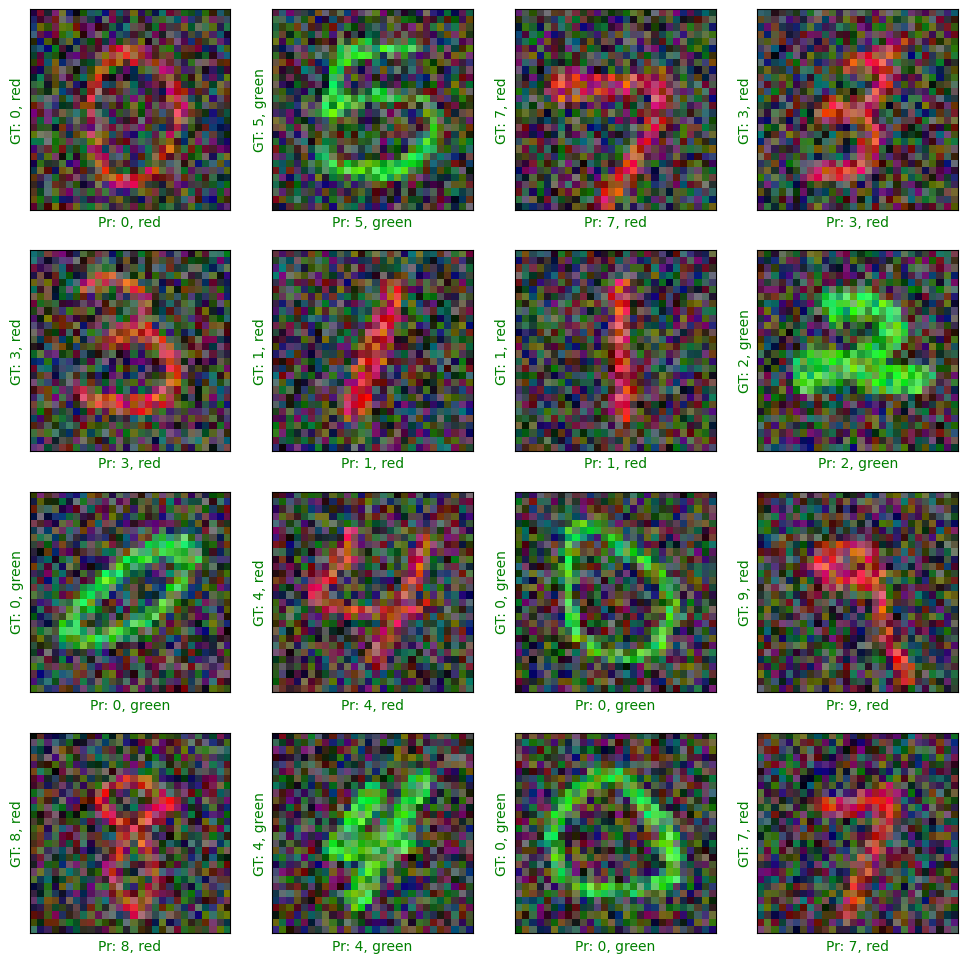

In [21]:
plt.figure(figsize=(12, 12))
for i in range(0, 16):
  plt.subplot(4, 4, i+1)
  test_model(show=False)
plt.show